In [47]:
import numpy as np
import h5py
import pandas as pd
from keras.layers import Input, Dense
from keras import regularizers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.linear_model import LogisticRegression #logistic regression





In [48]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [20]:
#dataset = pd.read_csv('beijing_weather_2015_2017.csv', header=0, index_col=0)

dataset = pd.read_csv('merged_final.csv', header=0, index_col=0)


In [21]:
#dataset1 = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv', header=0, index_col=0)

dataset.columns

Index([u'air_pressure', u'air_temp', u'cumulative_rain_hours',
       u'cumulative_snow_hours', u'date', u'day', u'dew_point', u'hour',
       u'month', u'pm2.5', u'wind_dir', u'wind_speed', u'year'],
      dtype='object')

# LSTM

In [7]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('PRSA_data_2010.1.1-2014.12.31.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


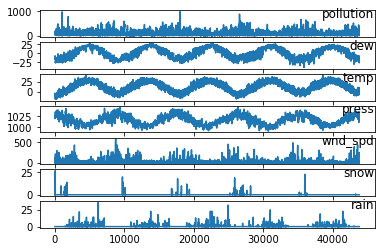

In [8]:

from pandas import read_csv
from matplotlib import pyplot
# load dataset
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  
((8760, 1, 8), (8760,), (35039, 1, 8), (35039,))
Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 2s - loss: 0.0619 - val_loss: 0.0512
Epoch 2/50
 - 1s - loss: 0.0438 - val_loss: 0.0570
Epoch 3/50
 - 1s - loss: 0.0285 - val_loss: 0.0515
Epoch 4/50
 - 1s - loss: 0.0187 - val_loss: 0.0409
Epoch 5/50
 - 1s - loss: 0.0161 - val_loss: 0.0284
Epoc

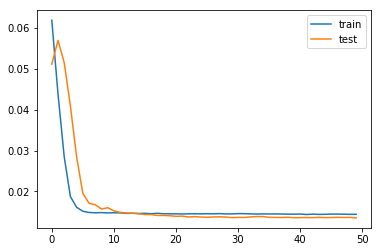

Test RMSE: 26.463


In [9]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	agg = concat(cols, axis=1)
	agg.columns = names
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
values = dataset.values
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())
 
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

RMSE for LSTM model is 26.463

In [32]:
dataset.head()

dataset.dtypes
#dataset.columns

air_pressure             float64
air_temp                 float64
cumulative_rain_hours    float64
cumulative_snow_hours     object
date                      object
day                        int64
dew_point                  int64
hour                       int64
month                      int64
pm2.5                    float64
wind_dir                  object
wind_speed               float64
year                       int64
dtype: object

## LOGISTIC REGRESSION

In [42]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
dataset1=dataset[['air_pressure','air_temp','cumulative_rain_hours','day','dew_point','hour','month','year']]
train_idx = np.random.choice(range(len(dataset1)), int(len(dataset1) * .666), replace=False)
test_idx = list(set(range(len(dataset1))) - set(list(train_idx)))

train_x = dataset1.loc[train_idx]
train_y = dataset['pm2.5'].loc[train_idx]
test_x = dataset1.loc[test_idx]
test_y = dataset['pm2.5'].loc[test_idx]

regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)
pred = regr.predict(test_x)

print(pred.shape)
print(test_y.shape)

print("Mean squared error: %.2f"% mean_squared_error(pred, test_y))



(23036,)
(23036,)
Mean squared error: 6869.45


In [5]:
from sklearn import svm

In [4]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
dataset1=dataset[['air_pressure','air_temp','cumulative_rain_hours','day','dew_point','hour','month','year']]
train_idx = np.random.choice(range(len(dataset1)), int(len(dataset1) * .666), replace=False)
test_idx = list(set(range(len(dataset1))) - set(list(train_idx)))

train_x = dataset1.loc[train_idx]
train_y = dataset['pm2.5'].loc[train_idx]
test_x = dataset1.loc[test_idx]
test_y = dataset['pm2.5'].loc[test_idx]

svr = svm.SVR(kernel='rbf')
svr.fit(train_x, train_y)
pred = svr.predict(test_x)

print(pred.shape)
print(test_y.shape)

print("Mean squared error: %.2f"% mean_squared_error(pred, test_y))




NameError: name 'dataset' is not defined

RMSE is 82.9 for the linear regression

## AUTO ENCODERS

In [55]:

from keras.datasets import mnist
from keras.models import Model




In [56]:
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.fit(train_x, train_x,
                epochs=50,
                batch_size=256,
                shuffle=True,
                )

NameError: name 'input_layer' is not defined

In [58]:
input_dim = train_x.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [65]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(train_x, train_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(train_x, train_x),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

ValueError: could not broadcast input array from shape (8,1) into shape (8)

In [64]:
predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

ValueError: could not broadcast input array from shape (8,1) into shape (8)